In [2]:
import pyreadr
import rpy2
import pyarrow.parquet as pq
import os, os.path
import numpy as np
import pandas as pd
import json
import time
from collections import defaultdict
import pyreadr
import rpy2
import pyarrow.parquet as pq
import re
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['R_HOME'] = 'D:/Users/Chenhao/anaconda3/envs/RPSHA/Lib/R'
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
RPSHA = importr("RPSHA")
####Convert RrupRjb function to tbe callable in python and rename it as rRrupRjb
rRrupRjb = robjects.r['RrupRjb']
#dir(RPSHA)

In [6]:
####Read sites information
sites = pd.read_csv('D:/Users/JupyterNotebook/StoEvtHaz/RegionalHazard_LASSO/input/sites_dlt.csv')
sites_id = sites['ID'].values

decimals = 2    
sites['X'] = sites['X'].apply(lambda x: round(x, decimals))
sites['Y'] = sites['Y'].apply(lambda x: round(x, decimals))

sites_x = sites['X'].values
sites_y = sites['Y'].values
#sites_x

In [13]:
####Input variables
one_pt_in_region = [38.05, -121.54]
max_distance = 130
im_name = 'PGA'

rp_name = ['10rp', '50rp', '100rp', '225rp', '475rp', '2475rp']
rp_value = [10, 50, 100, 225, 475, 2475]
max_d = 200

fault_threshold = 5
point_threshold = 3

example_site_index = [0,56,154] ####Sites indices you wanna compare harzard matching curve
nshmp_hazard_loc = 'D:/Users/JupyterNotebook/StoEvtHaz/RegionalHazard_LASSO/deagg/'

#column_index = 23

In [10]:
####Read all events in UCERF3
result = pyreadr.read_r('D:/Users/JupyterNotebook/StoEvtHaz/RegionalHazard_LASSO/input/FM31_Pts.rda')
FM31_Pts = result["FM31_Pts"]


result = pyreadr.read_r('D:/Users/JupyterNotebook/StoEvtHaz/RegionalHazard_LASSO/input/FM31_Secs.rda')
FM31_Secs = result["FM31_Secs"]

result = pyreadr.read_r('D:/Users/JupyterNotebook/StoEvtHaz/RegionalHazard_LASSO/input/FM32_Pts.rda')
FM32_Pts = result["FM32_Pts"]


result = pyreadr.read_r('D:/Users/JupyterNotebook/StoEvtHaz/RegionalHazard_LASSO/input/FM32_Secs.rda')
FM32_Secs = result["FM32_Secs"]

#FM31 Ruptures
FM31_Rups = pq.read_table('D:/Users/JupyterNotebook/StoEvtHaz/RegionalHazard_LASSO/input/FM31_Rups.parquet').to_pandas()
FM31_Rups

#FM32 Ruptures
FM32_Rups = pq.read_table('D:/Users/JupyterNotebook/StoEvtHaz/RegionalHazard_LASSO/input/FM32_Rups.parquet').to_pandas()
#FM32_Rups

FM31_Rups

,Index,Indices,Mag,Rate,Type,Depth,Dip,Rake,Width,ID
0,[0:1],"[0, 1]",[6.449],[3.3631184e-05],[SINGLE],[1.3],[50.0],[-90.0],[15.273],[1]
1,[0:2],"[0, 1, 2]",[6.638],[1.534016e-05],[SINGLE],[1.3],[50.0],[-90.0],[15.273],[2]
2,[0:3],"[0, 1, 2, 3]",[6.78],[1.090303e-05],[SINGLE],[1.3],[50.0],[-90.0],[15.273],[3]
3,[0:4],"[0, 1, 2, 3, 4]",[6.893],[7.3397665e-06],[SINGLE],[1.3],[50.0],[-90.0],[15.273],[4]
4,[0:5],"[0, 1, 2, 3, 4, 5]",[6.988],[3.9774597e-05],[SINGLE],[1.3],[50.0],[-90.0],[15.273],[5]
...,...,...,...,...,...,...,...,...,...,...
253604,[2473:2475],"[2473, 2474, 2475]",[6.496],[4.4253078e-07],[SINGLE],[1.2],[60.0],[-90.0],[12.471],[253605]
253605,[2473:2476],"[2473, 2474, 2475, 2476]",[6.637],[7.0331052e-06],[SINGLE],[1.2],[60.0],[-90.0],[12.471],[253606]
253606,[2474:2475],"[2474, 2475]",[6.303],[6.8217923e-07],[SINGLE],[1.2],[60.0],[-90.0],[12.471],[253607]
253607,[2474:2476],"[2474, 2475, 2476]",[6.496],[1.5162712e-05],[SINGLE],[1.2],[60.0],[-90.0],[12.471],[253608]


In [11]:
####Extract staring and ending trace lon and lat from FM31 and FM32 Secs

pattern = re.compile(r'-?\d+\.\d+,-?\d+\.\d+(?=,)')
FM31_BeEn_Trace = []
FM32_BeEn_Trace = []

for i in range(len(FM31_Secs)):
    # Find the first and last matches of the pattern in the input string
    matches = np.unique(pattern.findall(FM31_Secs.iloc[i][7])).tolist()

    lon_lat_list = []
    for j in range(len(matches)-1):
        
        # Extract the first and next lon and lat combinations and convert to float
        first_lon, first_lat = map(float, matches[j].split(','))
        last_lon, last_lat = map(float, matches[j+1].split(','))
    
        # Create a list with the first and last lon and lat combinations
        lon_lat_list.append([(first_lon, first_lat), (last_lon, last_lat)])
    
    FM31_BeEn_Trace.append(lon_lat_list)

for i in range(len(FM32_Secs)):
    # Find the first and last matches of the pattern in the input string
    matches = np.unique(pattern.findall(FM32_Secs.iloc[i][7])).tolist()

    lon_lat_list = []
    for j in range(len(matches)-1):
        
        # Extract the first and next lon and lat combinations and convert to float
        first_lon, first_lat = map(float, matches[j].split(','))
        last_lon, last_lat = map(float, matches[j+1].split(','))
    
        # Create a list with the first and last lon and lat combinations
        lon_lat_list.append([(first_lon, first_lat), (last_lon, last_lat)])

        # Create a list with the first and last lon and lat combinations
        lon_lat_list.append([(first_lon, first_lat), (last_lon, last_lat)])
    
    FM32_BeEn_Trace.append(lon_lat_list)
    
print(len(FM31_BeEn_Trace), len(FM32_BeEn_Trace))

2606 2664


In [12]:
####IMPORT FUNCTIONS IN R PACKAGES
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

revents_hazmat_calc = robjects.r['events_hazmat_calc']
rscenario_selection = robjects.r['scenario_selection']
rflts_filter = robjects.r['flts_filter']
rpts_filter = robjects.r['pts_filter']

flt_fm31f = rflts_filter(one_pt_in_region[0], one_pt_in_region[1], max_dist = max_distance, branch = 1) ##Any one point in your region; maximum distance
flt_fm31f = ro.conversion.get_conversion().rpy2py(flt_fm31f)


flt_fm32f = rflts_filter(one_pt_in_region[0], one_pt_in_region[1],max_dist = max_distance, branch = 2)
flt_fm32f = ro.conversion.rpy2py(flt_fm32f)
flt_fm32f

flt_fm32p = rpts_filter(one_pt_in_region[0], one_pt_in_region[1],max_dist = max_distance, branch = 2)
flt_fm32p = ro.conversion.rpy2py(flt_fm32p)
flt_fm32p

flt_fm31p = rpts_filter(one_pt_in_region[0], one_pt_in_region[1],max_dist = max_distance, branch = 1)
flt_fm31p = ro.conversion.rpy2py(flt_fm31p)


# PGA matching input files

In [14]:
#####Target Hazard files

###PGA
###Change yo your PSHA result file path
PGA_HAZ = pd.read_csv(nshmp_hazard_loc + '/10rp/PGA/curves.csv', header = None) # Either return priod gets the same results

IM_level = PGA_HAZ.loc[0].tolist()[3:]
IM1 = [im_name]*len(sites)*len(IM_level)   #### Change to the name of IM your are interested in

###IM level
IM_L = []
for i in range(len(IM_level)):
    for j in range(len(sites)):
        IM_L.append(str(IM_level[i]))
len(IM_L)

#### Site names
site_name_single = PGA_HAZ.iloc[:,0].tolist()[1:]
site_name = site_name_single*len(IM_level)


####Annual exceedance Rate
AER = []
for i in range(3, PGA_HAZ.shape[1]):
    temp = PGA_HAZ.iloc[:,i].tolist()[1:]
    AER = AER + temp
    
Y_Haz = pd.DataFrame(list(zip(IM1, IM_L, site_name, AER)), columns=['IM_type', 'IM_level', 'SiteName', 'AnnualExceedanceRate'])
Y_Haz

####Adjust the fitting range
Y_Haz = Y_Haz.iloc[785:2512,:]    ####Select your range of interest

In [9]:
#Y_Haz.to_csv('C:/Users/liuze/OneDrive/Desktop/Delta_Scenarios/PGA_yhaz.csv')

In [15]:
##### Site Table Input files

z1 = [-999]*len(sites)
vs = [350]*len(sites)
SiteTable = pd.DataFrame(list(zip(site_name_single, sites_x, sites_y, vs, z1)), columns=['SiteName', 'Lon', 'Lat', 'Vs30', 'z1'])
SiteTable

,SiteName,Lon,Lat,Vs30,z1
0,Delta Site1,-121.90,38.05,350,-999
1,Delta Site2,-121.90,38.00,350,-999
2,Delta Site3,-121.85,38.09,350,-999
3,Delta Site4,-121.85,38.05,350,-999
4,Delta Site5,-121.85,38.00,350,-999
...,...,...,...,...,...
152,Delta Site153,-121.27,37.78,350,-999
153,Delta Site154,-121.27,37.73,350,-999
154,Delta Site155,-121.27,37.69,350,-999
155,Delta Site156,-121.22,37.73,350,-999


In [9]:
#SiteTable.to_csv('C:/Users/liuze/OneDrive/Desktop/Delta_Scenarios/site_table.csv')

In [16]:
######Deaggregation results input files

SiteName = []
R_distance = []
Magnitude = []
HazardContribution = []
Epsilon_bar = []
IM_type = []
IM_level = []
ReturnPeriod = []
AnnualExceedanceRate = []
    
for j in range(len(rp_name)):
    rp_path_pga = rp_name[j]+'/PGA/deagg'     ######You may wanna modify this to fit your scenario
    RP = rp_value[j]
    
    #parent directory for PGA and PGV 
    parent_directory_pga = nshmp_hazard_loc+rp_path_pga    ######You may wanna modify this to your scenario
    
    
    filespath_pga = []
    im_filepath_pga = []
    

    for i in range(len(site_name_single)):
        filespath_pga.append(parent_directory_pga+'/'+site_name_single[i]+'/data.csv')
        
        im_filepath_pga.append(parent_directory_pga+'/'+site_name_single[i]+'/summary.txt')
        
    target_pga = []

    #For target PGA

    for path in im_filepath_pga:
        with open(path, 'r', encoding='utf-8') as file:
            for line_number, line in enumerate(file, 1):
                if line_number == 7:
                    target_pga.append(float(line.strip().split()[-2]))
                    break


    #For bin data of PGA
    for i in range(len(filespath_pga)):
        temp = pd.read_csv(filespath_pga[i])
        
        if len(temp[temp[temp.columns[0]]>max_d].index)>0:
            index_to_remove = temp[temp[temp.columns[0]]>max_d].index[0]
            temp = temp.loc[:index_to_remove]

        temp[temp.columns[5]] = pd.to_numeric(temp[temp.columns[5]], errors='coerce')
        temp.dropna(subset=[temp.columns[5]], inplace=True)

        IM_level.extend([target_pga[i]]*len(temp))
        SiteName.extend([site_name_single[i]]*len(temp))
        R_distance.extend(temp[temp.columns[0]].tolist())
        Magnitude.extend(temp[temp.columns[2]].tolist())
        HazardContribution.extend(temp[temp.columns[5]].tolist())
        Epsilon_bar.extend(temp[temp.columns[4]].tolist())
        IM_type.extend(['PGA']*len(temp))
        ReturnPeriod.extend([RP]*len(temp))
        AnnualExceedanceRate.extend([1/RP]*len(temp))


Y_Deagg = pd.DataFrame(list(zip(ReturnPeriod, AnnualExceedanceRate, IM_level, IM_type, SiteName, R_distance, Magnitude,HazardContribution,
                               Epsilon_bar)), 
                       columns=['ReturnPeriod', 'AnnualExceedanceRate','IM_level', 'IM_type', 'SiteName', 'R_distance', 'Magnitude',
                               'HazardContribution', 'Epsilon_bar'])
Y_Deagg

,ReturnPeriod,AnnualExceedanceRate,IM_level,IM_type,SiteName,R_distance,Magnitude,HazardContribution,Epsilon_bar
0,10,0.100000,0.048430,PGA,Delta Site1,10.0,5.1,3.85,-0.81
1,10,0.100000,0.048430,PGA,Delta Site1,10.0,5.3,3.21,-1.35
2,10,0.100000,0.048430,PGA,Delta Site1,10.0,5.5,2.44,-1.92
3,10,0.100000,0.048430,PGA,Delta Site1,10.0,5.7,1.61,-2.13
4,10,0.100000,0.048430,PGA,Delta Site1,10.0,5.9,1.02,-2.35
...,...,...,...,...,...,...,...,...,...
79686,2475,0.000404,0.524751,PGA,Delta Site157,70.0,7.9,0.05,2.36
79687,2475,0.000404,0.524751,PGA,Delta Site157,70.0,8.1,0.10,2.16
79688,2475,0.000404,0.524751,PGA,Delta Site157,90.0,7.9,0.14,2.83
79689,2475,0.000404,0.524751,PGA,Delta Site157,90.0,8.1,0.43,2.63


In [224]:
#Y_Deagg.to_csv('C:/Users/liuze/OneDrive/Desktop/Delta_Scenarios/PGA_ydeagg.csv')

# Pre-select events based on deaggregation result

In [17]:
import time

In [18]:
####index sites first, and then index bins
start_time = time.time()
###threshold set up

fault_candid_bin = Y_Deagg[(Y_Deagg['HazardContribution'] >= fault_threshold)]
fault_candid_bin = fault_candid_bin.sort_values(by=['SiteName'], ascending=True)
point_candid_bin = Y_Deagg[(Y_Deagg['HazardContribution'] >= point_threshold)]
point_candid_bin = point_candid_bin.sort_values(by=['SiteName'], ascending=True)

fm31_candid_f = pd.DataFrame(columns=flt_fm31f.columns)
fm31_candid_p = pd.DataFrame(columns=flt_fm31p.columns)
fm32_candid_f = pd.DataFrame(columns=flt_fm32f.columns)
fm32_candid_p = pd.DataFrame(columns=flt_fm31p.columns)

###Site index
f_site = fault_candid_bin['SiteName'].values
f_site = np.unique(f_site)
p_site = point_candid_bin['SiteName'].values
p_site = np.unique(p_site)

####Select Fault rupture
for name in f_site:
    
    result_df = fault_candid_bin[fault_candid_bin['SiteName'] == name]
    target_pt_idx = int(name[10:])-1
    flt_fm31f_u = rflts_filter(sites_y[target_pt_idx], sites_x[target_pt_idx], max_dist = max_distance, branch = 1)
    flt_fm31f_u = ro.conversion.get_conversion().rpy2py(flt_fm31f_u)
    flt_fm32f_u = rflts_filter(sites_y[target_pt_idx], sites_x[target_pt_idx], max_dist = max_distance, branch = 2)
    flt_fm32f_u = ro.conversion.get_conversion().rpy2py(flt_fm32f_u)
    
    for i, row in result_df.iterrows():
        ll_r = row['R_distance']-10
        ul_r = row['R_distance']+10
        ll_m = row['Magnitude']-0.1
        ul_m = row['Magnitude']+0.1
        
        candid = flt_fm31f_u[(flt_fm31f_u['Rjb']>=ll_r) & (flt_fm31f_u['Rjb']<=ul_r) & (flt_fm31f_u['Mag']>=ll_m) & (flt_fm31f_u['Mag']<=ul_m)]
        if len(candid)>0:
            random_row = candid.sample(n=1)
            fm31_candid_f = pd.concat([fm31_candid_f,random_row], ignore_index=True)
            
        candid = flt_fm32f_u[(flt_fm32f_u['Rjb']>=ll_r) & (flt_fm32f_u['Rjb']<=ul_r) & (flt_fm32f_u['Mag']>=ll_m) & (flt_fm32f_u['Mag']<=ul_m)]
        if len(candid)>0:
            random_row = candid.sample(n=1)
            fm32_candid_f = pd.concat([fm32_candid_f,random_row], ignore_index=True)
            
###Select POINT sources
for name in p_site:
    
    result_df = point_candid_bin[point_candid_bin['SiteName'] == name]
    target_pt_idx = int(name[10:])-1
    flt_fm31p_u = rpts_filter(sites_y[target_pt_idx], sites_x[target_pt_idx], max_dist = max_distance, branch = 1)
    flt_fm31p_u = ro.conversion.get_conversion().rpy2py(flt_fm31p_u)
    flt_fm32p_u = rpts_filter(sites_y[target_pt_idx], sites_x[target_pt_idx], max_dist = max_distance, branch = 2)
    flt_fm32p_u = ro.conversion.get_conversion().rpy2py(flt_fm32p_u)
    
    for i, row in result_df.iterrows():
        ll_r = row['R_distance']-10
        ul_r = row['R_distance']+10
        ll_m = row['Magnitude']-0.1
        ul_m = row['Magnitude']+0.1
        
        candid = flt_fm31p_u[(flt_fm31p_u['Rjb']>=ll_r) & (flt_fm31p_u['Rjb']<=ul_r) & (flt_fm31p_u['Mag']>=ll_m) & (flt_fm31p_u['Mag']<=ul_m)]
        if len(candid)>0:
            random_row = candid.sample(n=1)
            fm31_candid_p = pd.concat([fm31_candid_p,random_row], ignore_index=True)
            
        candid = flt_fm32p_u[(flt_fm32p_u['Rjb']>=ll_r) & (flt_fm32p_u['Rjb']<=ul_r) & (flt_fm32p_u['Mag']>=ll_m) & (flt_fm32p_u['Mag']<=ul_m)]
        if len(candid)>0:
            random_row = candid.sample(n=1)
            fm32_candid_p = pd.concat([fm32_candid_p,random_row], ignore_index=True)
            
            
fm31_candid_f = fm31_candid_f.drop_duplicates(subset=['ID'], keep='first')
fm31_candid_f.reset_index(drop=True, inplace=True)

fm32_candid_f = fm32_candid_f.drop_duplicates(subset=['ID'], keep='first')
fm32_candid_f.reset_index(drop=True, inplace=True)


fm31_candid_p = fm31_candid_p.drop_duplicates(subset=['ID'], keep='first')
fm31_candid_p.reset_index(drop=True, inplace=True)

fm32_candid_p = fm32_candid_p.drop_duplicates(subset=['ID'], keep='first')
fm32_candid_p.reset_index(drop=True, inplace=True)

end_time = time.time()
print('Number of rupture sources',len(fm32_candid_f)+len(fm31_candid_f))
print('Number of point sources',len(fm32_candid_p)+len(fm31_candid_p))
print('execution time:'+ str(end_time-start_time))

Number of rupture sources 786
Number of point sources 621
execution time:6773.103655099869


In [24]:
#flt_fm32f_u
#flt_fm32f_u = ro.conversion.get_conversion().rpy2py(flt_fm32f_u)

In [19]:
fm31_candid_p

,ID,Fault_Type,Weight,Mag,Rate,Longitude,Latitude,Rrup,Rjb
0,3346.0,2.0,9.000000e-10,5.15,1.316266e-04,-121.8,37.9,18.863262,18.863262
1,3507.0,2.0,3.103000e-07,6.35,3.884331e-06,-121.9,38.2,16.697924,16.697924
2,3344.0,1.0,5.000000e-01,6.45,2.579648e-06,-122.0,37.9,18.863262,18.863262
3,3400.0,2.0,2.330000e-08,6.65,1.812093e-06,-121.8,38.0,10.386397,10.386397
4,3399.0,1.0,5.000000e-01,6.95,4.751842e-09,-121.9,38.0,5.565975,5.565975
...,...,...,...,...,...,...,...,...,...
308,3721.0,3.0,4.101275e-01,6.15,1.126717e-06,-121.1,38.6,40.019970,40.019970
309,3860.0,2.0,1.897712e-04,6.25,4.142126e-06,-122.0,38.9,70.291504,70.291504
310,3914.0,1.0,5.095251e-01,6.55,7.491221e-07,-121.4,39.0,76.100436,76.100436
311,3868.0,2.0,2.099973e-01,7.35,2.290427e-08,-121.2,38.9,74.533037,74.533037


In [20]:
#### Event set file
Fault_type = {1.0: 'SS', 2.0:'N', 3.0:'R'}

###FM31 Point Sources
col_num = len(sites)
row_num = len(fm31_candid_p)
info_mat3 = np.zeros([row_num, 4] , dtype=object)

for i, row1 in fm31_candid_p.iterrows():
    info_mat3[i][0] = 'FM31_'+ str(row1['Longitude'])+','+str(row1['Latitude'])+',0.0'+'_'+Fault_type[row1['Fault_Type']]
    info_mat3[i][1] = row1['Mag']
    info_mat3[i][2] = row1['Rate']
    info_mat3[i][3] = Fault_type[row1['Fault_Type']]
        
        
###FM32 Point Sources
col_num = len(sites)
row_num = len(fm32_candid_p)
info_mat4 = np.zeros([row_num, 4] , dtype=object)

for i, row1 in fm32_candid_p.iterrows():
    info_mat4[i][0] = 'FM32_'+ str(row1['Longitude'])+','+str(row1['Latitude'])+',0.0'+'_'+Fault_type[row1['Fault_Type']]
    info_mat4[i][1] = row1['Mag']
    info_mat4[i][2] = row1['Rate']
    info_mat4[i][3] = Fault_type[row1['Fault_Type']]
        
        
###FM 31 Ruptures sources
col_num = len(sites)
row_num = len(fm31_candid_f)
info_mat1 = np.zeros([row_num, 4] , dtype=object)

for i in range(len(fm31_candid_f)):
    info_mat1[i][0] = 'FM31_'+fm31_candid_f.iloc[i][0]
    info_mat1[i][1] = fm31_candid_f.iloc[i][1]
    info_mat1[i][2] = fm31_candid_f.iloc[i][2]
    info_mat1[i][3] = 'SS'
        
        
###FM 32 Ruptures sources
col_num = len(sites)
row_num = len(fm32_candid_f)
info_mat2 = np.zeros([row_num, 4] , dtype=object)

for i in range(len(fm32_candid_f)):
    info_mat2[i][0] = 'FM32_'+fm32_candid_f.iloc[i][0]
    info_mat2[i][1] = fm32_candid_f.iloc[i][1]
    info_mat2[i][2] = fm32_candid_f.iloc[i][2]
    info_mat2[i][3] = 'SS'


In [21]:
#FM31_Rups['ID'] = FM31_Rups['ID'].apply(lambda arr: arr.item())
#FM32_Rups['ID'] = FM32_Rups['ID'].apply(lambda arr: arr.item())

In [22]:
fm31_indices = []
fm32_indices = []
####organize subsection information for potential eventsets
for i in range(len(fm31_candid_f)):
    index = FM31_Rups.index[FM31_Rups['ID'] == fm31_candid_f.iloc[i][9]][0]
    fm31_indices.append(FM31_Rups.iloc[index][1])
fm31_indices  

for i in range(len(fm32_candid_f)):
    index = FM32_Rups.index[FM32_Rups['ID'] == fm32_candid_f.iloc[i][9]][0]
    fm32_indices.append(FM32_Rups.iloc[index][1])
#fm32_indices  

In [23]:
###Calculate Rjb for fault eventset to sites
start_time = time.time()
row_num = len(fm31_candid_f)
col_num = len(sites)
dist_mat1 = np.zeros([row_num, col_num])

sites_lon = np.array(sites_x, dtype=float)
sites_lat = np.array(sites_y, dtype=float)

# Convert NumPy arrays to R vectors
slon_r = robjects.vectors.FloatVector(sites_lon)
slat_r = robjects.vectors.FloatVector(sites_lat)

for i, row1 in fm31_candid_f.iterrows():
    trace = row1['Index']
    range_strings = trace.split(',')

    rjb_list = []
    for j in fm31_indices[i]:
        
        temp = []
        for k in range(len(FM31_BeEn_Trace[j])):

            rRes = rRrupRjb(fflat1 = FM31_BeEn_Trace[j][k][0][1], fflon1 = FM31_BeEn_Trace[j][k][0][0], 
                            fflat2 = FM31_BeEn_Trace[j][k][1][1], fflon2 = FM31_BeEn_Trace[j][k][1][0], 
                            fdip = row1['Dip'], topd = row1['Depth'], 
                            width = row1['Width'],slon = slon_r, slat = slat_r)

            Res = dict(zip(rRes.names, map(list, list(rRes))))
            temp.append(Res['Rjb'])
            
        rjb_list.append(np.min(temp))

    # Calculate min Rjb from each segments
    dist_mat1[i] = np.min(rjb_list, axis=0)

print(np.shape(dist_mat1))

row_num = len(fm32_candid_f)
dist_mat2 = np.zeros([row_num, col_num])

for i, row1 in fm32_candid_f.iterrows():
    trace = row1['Index']
    range_strings = trace.split(',')

    rjb_list = []
    for j in fm32_indices[i]:
        
        temp = []
        for k in range(len(FM32_BeEn_Trace[j])):

            rRes = rRrupRjb(fflat1 = FM32_BeEn_Trace[j][k][0][1], fflon1 = FM32_BeEn_Trace[j][k][0][0], 
                            fflat2 = FM32_BeEn_Trace[j][k][1][1], fflon2 = FM32_BeEn_Trace[j][k][1][0], 
                            fdip = row1['Dip'], topd = row1['Depth'], 
                            width = row1['Width'],slon = slon_r, slat = slat_r)

            Res = dict(zip(rRes.names, map(list, list(rRes))))
            temp.append(Res['Rjb'])
        rjb_list.append(np.min(temp))

    # Calculate min Rjb from each segments
    dist_mat2[i] = np.min(rjb_list, axis=0)

print(np.shape(dist_mat2))

end_time = time.time()
print('execution time:'+ str(end_time-start_time))

(394, 157)
(392, 157)
execution time:331.37302923202515


In [25]:
###FM31 Point Sources

def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the haversine distance between two points (lon1, lat1) and (lon2, lat2) in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    radius = 6371  # Earth's radius in kilometers
    distance = radius * c

    return distance

col_num = len(sites)
row_num = len(fm31_candid_p)
dist_mat3 = np.zeros([row_num, col_num])

for i, row1 in fm31_candid_p.iterrows():
  
    for j, row2 in sites.iterrows():
        dist_mat3[i][j] = haversine_distance(row1['Longitude'], row1['Latitude'], row2['X'], row2['Y'])
        
        
###FM32 Point Sources

col_num = len(sites)
row_num = len(fm32_candid_p)
dist_mat4 = np.zeros([row_num, col_num])

for i, row1 in fm32_candid_p.iterrows():

    for j, row2 in sites.iterrows():
        dist_mat4[i][j] = haversine_distance(row1['Longitude'], row1['Latitude'], row2['X'], row2['Y'])
        

In [26]:
####Concatenate results
mat1 = np.concatenate((info_mat1, dist_mat1), axis = 1)
mat2 = np.concatenate((info_mat2, dist_mat2), axis = 1)
mat3 = np.concatenate((info_mat3, dist_mat3), axis = 1)
mat4 = np.concatenate((info_mat4, dist_mat4), axis = 1)

mat_t = np.concatenate((mat1, mat2,mat3,mat4), axis = 0)


####Construct Event Set file

column_name = []

for i in range(len(sites)):
    column_name.append('Rjb to Site'+str(i+1))
column_name = ['EventID', 'Magnitude', 'AnnualOccurrenceRate','Fault_type'] + column_name

EventSet = pd.DataFrame(data = mat_t,  columns = column_name)
EventSet

,EventID,Magnitude,AnnualOccurrenceRate,Fault_type,Rjb to Site1,Rjb to Site2,Rjb to Site3,Rjb to Site4,Rjb to Site5,Rjb to Site6,...,Rjb to Site148,Rjb to Site149,Rjb to Site150,Rjb to Site151,Rjb to Site152,Rjb to Site153,Rjb to Site154,Rjb to Site155,Rjb to Site156,Rjb to Site157
0,"FM31_780,779",5.401,0.0,SS,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709,...,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709
1,FM31_785:788,6.282,0.000014,SS,10.80093,10.80093,10.80093,10.80093,10.80093,10.80093,...,10.80093,10.80093,10.80093,10.80093,10.80093,10.80093,10.80093,10.80093,10.80093,10.80093
2,"FM31_780:775,952:955",6.521,0.000011,SS,18.595426,18.595426,18.595426,18.595426,18.595426,18.595426,...,18.595426,18.595426,18.595426,18.595426,18.595426,18.595426,18.595426,18.595426,18.595426,18.595426
3,FM31_712:713,6.165,0.000707,SS,5.6213,5.6213,5.6213,5.6213,5.6213,5.6213,...,5.6213,5.6213,5.6213,5.6213,5.6213,5.6213,5.6213,5.6213,5.6213,5.6213
4,"FM31_347:346,781:778",6.213,0.00002,SS,11.492978,11.492978,11.492978,11.492978,11.492978,11.492978,...,11.492978,11.492978,11.492978,11.492978,11.492978,11.492978,11.492978,11.492978,11.492978,11.492978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,"FM32_-121.7,39.1,0.0_R",6.65,0.000001,R,118.04199,123.54466,113.060872,117.480525,123.007944,82.835614,...,140.918933,146.323804,150.655815,156.079987,165.866118,151.479189,156.875436,161.200433,157.972246,162.268592
1403,"FM32_-121.3,39.1,0.0_R",6.55,0.0,R,127.874804,132.977445,122.054881,126.164466,131.332437,93.422252,...,136.772529,142.332169,146.779887,152.339541,162.346933,146.800554,152.359468,156.806641,152.496395,156.939761
1404,"FM32_-121.0,38.9,0.0_SS",6.75,0.0,SS,122.764396,127.110942,116.550664,120.033574,124.473684,92.498053,...,117.674608,123.094465,127.439027,132.879335,142.695091,126.744831,132.213252,136.593297,131.506182,135.908643
1405,"FM32_-122.3,38.6,0.0_N",6.25,0.0,N,70.411029,75.296053,68.963908,72.671267,77.415227,50.313224,...,118.597102,122.490317,125.695149,129.804266,137.458019,128.126397,132.161532,135.4674,135.177529,138.412965


In [140]:
EventSet['Magnitude'] = EventSet['Magnitude'].apply(lambda arr: arr.item())
EventSet['AnnualOccurrenceRate'] = EventSet['AnnualOccurrenceRate'].apply(lambda arr: arr.item())

Y_Haz['IM_level'] = Y_Haz['IM_level'].astype(float)
#Y_Haz.iloc[0][1]

In [226]:
EventSet.to_csv('C:/Users/liuze/OneDrive/Desktop/Delta_Scenarios/PGA_eventset.csv')

In [21]:
#PGA_val

In [55]:
#Y_Haz

In [23]:
#Y_Haz['IM_level'] = Y_Haz['IM_level'].astype(float)
#Y_Haz.iloc[0][1]
#yu

In [141]:
##### Change 158 to (the number of sites you have + 1)
for i in range(1, len(sites)+1):
    name = 'Rjb to Site'+str(i)
    EventSet[name] = EventSet[name].astype(float)

In [142]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

with (ro.default_converter + pandas2ri.converter).context():
    Y_Haz_r = ro.conversion.get_conversion().py2rpy(Y_Haz)
    
with (ro.default_converter + pandas2ri.converter).context():
    SiteTable_r = ro.conversion.get_conversion().py2rpy(SiteTable)
    
with (ro.default_converter + pandas2ri.converter).context():
    EventSet_r = ro.conversion.get_conversion().py2rpy(EventSet)

EventSet_r

EventID,Magnitude,AnnualOccurrenceRate,...,Rjb to Site155,Rjb to Site156,Rjb to Site157
...,...,...,...,...,...,...


In [143]:
Y_Haz_r

IM_type,IM_level,SiteName,AnnualExceedanceRate
...,...,...,...


In [144]:
X_haz = revents_hazmat_calc(Y_haz = Y_Haz_r, EventSet = EventSet_r, SiteTable = SiteTable_r)

[1] "The calculation is completed by 0%"
[1] "The calculation is completed by 1%"
[1] "The calculation is completed by 2%"
[1] "The calculation is completed by 3%"
[1] "The calculation is completed by 4%"
[1] "The calculation is completed by 5%"
[1] "The calculation is completed by 6%"
[1] "The calculation is completed by 7%"
[1] "The calculation is completed by 8%"
[1] "The calculation is completed by 9%"
[1] "The calculation is completed by 10%"
[1] "The calculation is completed by 11%"
[1] "The calculation is completed by 12%"
[1] "The calculation is completed by 13%"
[1] "The calculation is completed by 14%"
[1] "The calculation is completed by 15%"
[1] "The calculation is completed by 16%"
[1] "The calculation is completed by 17%"
[1] "The calculation is completed by 18%"
[1] "The calculation is completed by 19%"
[1] "The calculation is completed by 20%"
[1] "The calculation is completed by 21%"
[1] "The calculation is completed by 22%"
[1] "The calculation is completed by 23%"
[1

In [145]:
X_haz_p = ro.conversion.rpy2py(X_haz)
X_haz_p

,IM_type,IM_level,SiteName,"EventID_FM31_780,779","EventID_FM31_320,319","EventID_FM31_781:775,952:954","EventID_FM31_347:346,781:780","EventID_FM31_348:346,781:780","EventID_FM31_319:320,788:786","EventID_FM31_319:320,788:782,794:793",...,"EventID_FM32_-122.4,38.0,0.0_R","EventID_FM32_-121.3,39.1,0.0_N","EventID_FM32_-122.2,38.9,0.0_R","EventID_FM32_-120.7,38.7,0.0_R","EventID_FM32_-120.7,38.8,0.0_R","EventID_FM32_-121.7,39.1,0.0_N","EventID_FM32_-121.4,39.0,0.0_R","EventID_FM32_-120.7,38.6,0.0_R","EventID_FM32_-121.9,38.9,0.0_N","EventID_FM32_-121.0,38.8,0.0_SS"
785,PGA,0.0253,Delta Site1,9.654222e-11,5.413247e-06,2.746605e-05,1.096051e-05,1.524758e-04,1.036021e-06,1.601555e-06,...,3.189545e-11,8.244517e-08,1.462544e-06,3.459415e-07,2.815907e-07,4.155384e-07,4.182412e-07,3.995734e-07,1.262099e-06,3.004149e-08
786,PGA,0.0253,Delta Site2,9.654222e-11,5.413247e-06,2.746605e-05,1.096051e-05,1.524758e-04,1.036021e-06,1.601555e-06,...,3.190830e-11,7.078442e-08,1.300819e-06,3.213262e-07,2.621111e-07,3.520430e-07,3.734413e-07,3.709814e-07,1.102987e-06,2.796965e-08
787,PGA,0.0253,Delta Site3,9.654222e-11,5.413247e-06,2.746605e-05,1.096051e-05,1.524758e-04,1.036021e-06,1.601555e-06,...,3.166540e-11,9.748045e-08,1.554193e-06,3.948525e-07,3.170673e-07,4.800869e-07,4.709348e-07,4.626325e-07,1.391797e-06,3.320758e-08
788,PGA,0.0253,Delta Site4,9.654222e-11,5.413247e-06,2.746605e-05,1.096051e-05,1.524758e-04,1.036021e-06,1.601555e-06,...,3.170154e-11,8.666810e-08,1.424503e-06,3.739310e-07,3.006828e-07,4.224739e-07,4.324852e-07,4.381362e-07,1.259158e-06,3.153449e-08
789,PGA,0.0253,Delta Site5,9.654222e-11,5.413247e-06,2.746605e-05,1.096051e-05,1.524758e-04,1.036021e-06,1.601555e-06,...,3.171683e-11,7.439282e-08,1.265983e-06,3.474979e-07,2.800641e-07,3.578842e-07,3.863141e-07,4.069070e-07,1.100358e-06,2.938807e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,PGA,1.4600,Delta Site153,1.131851e-15,4.137448e-08,1.487312e-08,1.250503e-08,2.492564e-07,1.239985e-08,2.589101e-08,...,1.607184e-20,5.236983e-21,5.895002e-20,9.480092e-18,1.340227e-17,5.437834e-21,4.403794e-19,9.976313e-18,4.355922e-20,1.432384e-18
2508,PGA,1.4600,Delta Site154,1.131851e-15,4.137448e-08,1.487312e-08,1.250503e-08,2.492564e-07,1.239985e-08,2.589101e-08,...,1.285595e-20,2.978725e-21,3.614417e-20,5.736178e-18,8.300173e-18,3.109753e-21,2.529232e-19,4.259786e-18,2.550933e-20,8.462332e-19
2509,PGA,1.4600,Delta Site155,1.131851e-15,4.137448e-08,1.487312e-08,1.250503e-08,2.492564e-07,1.239985e-08,2.589101e-08,...,1.044503e-20,1.898859e-21,2.436231e-20,3.834074e-18,5.651588e-18,1.989220e-21,1.625405e-19,2.581889e-18,1.661150e-20,5.563141e-19
2510,PGA,1.4600,Delta Site156,1.131851e-15,4.137448e-08,1.487312e-08,1.250503e-08,2.492564e-07,1.239985e-08,2.589101e-08,...,6.888095e-21,2.937672e-21,2.831601e-20,6.838214e-18,9.658078e-18,2.776388e-21,2.426529e-19,5.947249e-18,2.124162e-20,9.115645e-19


In [146]:
col_names = ['AnnualExceedanceRate']  # Indices of columns you want to extract
Y = Y_Haz[col_names].values

excluded_columns = ['IM_type','IM_level', 'SiteName']

# Use .loc to extract all rows and columns except excluded columns
result_df = X_haz_p.loc[:, ~X_haz_p.columns.isin(excluded_columns)]
X = result_df.values
X

array([[9.65422195e-11, 5.41324725e-06, 2.74660478e-05, ...,
        3.99573415e-07, 1.26209922e-06, 3.00414904e-08],
       [9.65422195e-11, 5.41324725e-06, 2.74660478e-05, ...,
        3.70981392e-07, 1.10298724e-06, 2.79696464e-08],
       [9.65422195e-11, 5.41324725e-06, 2.74660478e-05, ...,
        4.62632530e-07, 1.39179745e-06, 3.32075789e-08],
       ...,
       [1.13185083e-15, 4.13744826e-08, 1.48731174e-08, ...,
        2.58188874e-18, 1.66115014e-20, 5.56314124e-19],
       [1.13185083e-15, 4.13744826e-08, 1.48731174e-08, ...,
        5.94724920e-18, 2.12416236e-20, 9.11564539e-19],
       [1.13185083e-15, 4.13744826e-08, 1.48731174e-08, ...,
        3.14557586e-18, 1.39094904e-20, 5.97539243e-19]])

In [147]:
Y_r = robjects.vectors.FloatVector(Y)
Y_r

import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

nr,nc = X.shape
X_r = ro.r.matrix(X, nrow=nr, ncol=nc)
X_r

array([[9.65422195e-11, 5.41324725e-06, 2.74660478e-05, ...,
        3.99573415e-07, 1.26209922e-06, 3.00414904e-08],
       [9.65422195e-11, 5.41324725e-06, 2.74660478e-05, ...,
        3.70981392e-07, 1.10298724e-06, 2.79696464e-08],
       [9.65422195e-11, 5.41324725e-06, 2.74660478e-05, ...,
        4.62632530e-07, 1.39179745e-06, 3.32075789e-08],
       ...,
       [1.13185083e-15, 4.13744826e-08, 1.48731174e-08, ...,
        2.58188874e-18, 1.66115014e-20, 5.56314124e-19],
       [1.13185083e-15, 4.13744826e-08, 1.48731174e-08, ...,
        5.94724920e-18, 2.12416236e-20, 9.11564539e-19],
       [1.13185083e-15, 4.13744826e-08, 1.48731174e-08, ...,
        3.14557586e-18, 1.39094904e-20, 5.97539243e-19]])

In [207]:
#max_rate_multiplier=10000
#max_rate_multiplier=12000
res = rscenario_selection(Y = Y_r, X = X_r)

Conduct selection 
  |======================================================================| 100%
Relaxed Fits
  |======================================================================| 100%
Prepare and output results 
  |======================================================================| 100%
 The results are not written into any files. 


In [209]:
pga_res = dict(zip(res.names, map(list, list(res))))
beta_mat = pga_res['betas']
yhat_mat = pga_res['Y_hat']
errors_mat = pga_res['errors_mat']
beta_mat

[array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 12000.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 15.66893515,
         0.        , 21.51447497,  0.        , 16.

In [228]:
np.shape(beta_mat)

(1416, 37)

In [211]:
#mean of squared logarithmic residuals, mean of absolute logarithmic relative errors, 
#and mean of absolute arithmetic relative errors

errors_mat

[array([ 1.        , 23.75030826,  0.57833755,  0.84063007]),
 array([ 2.        , 17.45608443,  0.43700534,  0.74348294]),
 array([ 3.        , 15.84016532,  0.34746183,  0.62796411]),
 array([5.        , 7.97315017, 0.22360074, 0.51672422]),
 array([6.        , 7.99379727, 0.22390855, 0.51696679]),
 array([7.        , 7.8367332 , 0.22191986, 0.51616181]),
 array([8.        , 7.85502038, 0.22211294, 0.51617994]),
 array([9.        , 7.02059985, 0.20444594, 0.49581848]),
 array([10.        ,  7.32329448,  0.2158748 ,  0.51436148]),
 array([11.        ,  7.01788582,  0.20441508,  0.4958036 ]),
 array([13.        ,  1.62873703,  0.09405401,  0.3584178 ]),
 array([14.        ,  1.35065176,  0.08441637,  0.33870362]),
 array([15.        ,  1.349664  ,  0.08437825,  0.33858335]),
 array([16.        ,  1.3235458 ,  0.08330828,  0.33643087]),
 array([17.        ,  1.23422599,  0.08085974,  0.33203996]),
 array([18.        ,  1.07146092,  0.07272354,  0.30913849]),
 array([19.        ,  1.0701

<IPython.core.display.Javascript object>


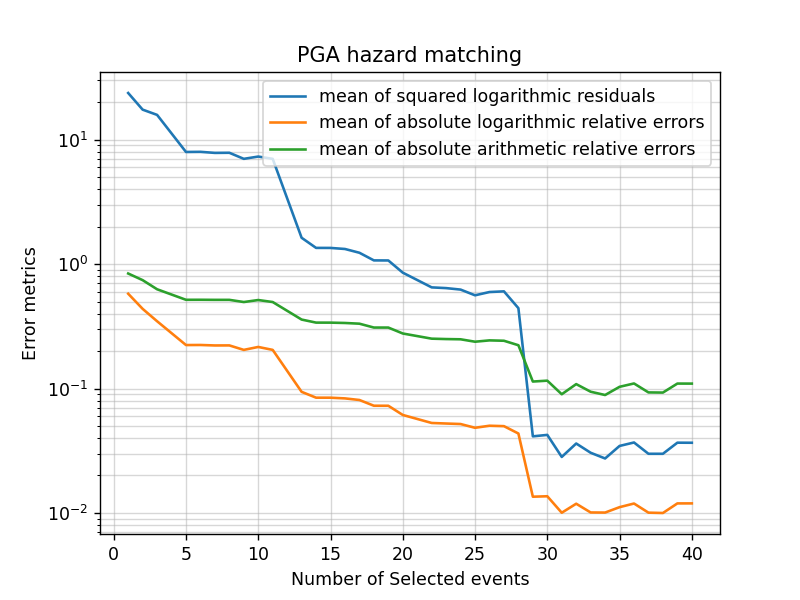

In [212]:
get_ipython().run_line_magic('matplotlib', 'notebook')
fig, ax = plt.subplots()

ax.set_xlabel('Number of Selected events')
ax.set_ylabel("Error metrics")
ax.set_yscale("log")
ax.set_title("PGA hazard matching")
x = [arr[0] for arr in errors_mat]  
y1= [arr[1] for arr in errors_mat]
y2= [arr[2] for arr in errors_mat]
y3= [arr[3] for arr in errors_mat]
ax.plot(x, y1, label='mean of squared logarithmic residuals')
ax.plot(x, y2, label='mean of absolute logarithmic relative errors')
ax.plot(x, y3, label='mean of absolute arithmetic relative errors')
ax.grid(True, alpha=0.5, which='both')
ax.legend(loc='upper right')

In [213]:
# get_ipython().run_line_magic('matplotlib', 'notebook')
# fig, ax = plt.subplots()

# ax.set_xlabel('Number of Selected events')
# ax.set_ylabel("Error metrics")
# ax.set_title("PGA hazard matching")
# x = [arr[0] for arr in errors_mat]  
# #y1= [arr[1] for arr in errors_mat]
# y2= [arr[2] for arr in errors_mat]
# y3= [arr[3] for arr in errors_mat]
# #ax.plot(x, y1, label='mean of squared logarithmic residuals')
# ax.plot(x, y2, label='mean of absolute logarithmic relative errors')
# ax.plot(x, y3, label='mean of absolute arithmetic relative errors')
# ax.grid(True, alpha=0.5, which='both')
# ax.legend(loc='upper right')

<IPython.core.display.Javascript object>


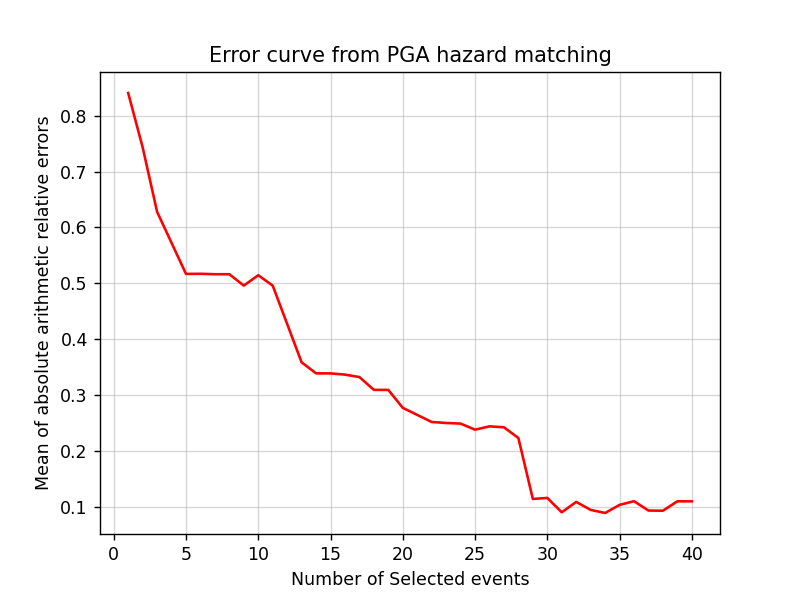

In [237]:
get_ipython().run_line_magic('matplotlib', 'notebook')
fig, ax = plt.subplots()

ax.set_xlabel('Number of Selected events')
ax.set_ylabel("Mean of absolute arithmetic relative errors")
#ax.set_yscale("log")
ax.set_title("Error curve from PGA hazard matching")
x = [arr[0] for arr in errors_mat]  
#y1= [arr[1] for arr in errors_mat]
#y2= [arr[2] for arr in errors_mat]
y3= [arr[3] for arr in errors_mat]
#ax.plot(x, y1, label='mean of squared logarithmic residuals')
#ax.plot(x, y2, label='mean of absolute logarithmic relative errors')
ax.plot(x, y3, c='red')
ax.grid(True, alpha=0.5, which='both')
#ax.legend(loc='upper right')

In [267]:
column_index=32
#column_index=15
PGA_val = []
target_y = []
predict_y = []

for i in range(len(Y_Haz)//len(sites)):
    PGA_val.append(Y_Haz.iloc[i*len(sites)][1])

for j in example_site_index:
    for i in range(len(Y_Haz)//len(sites)):
        target_y.append(Y_Haz.iloc[i*len(sites)+j][3])
        
for i in example_site_index:
    for j in range(len(Y_Haz)//len(sites)):
        predict_y.append(yhat_mat[j*len(sites)+i][column_index])

<IPython.core.display.Javascript object>


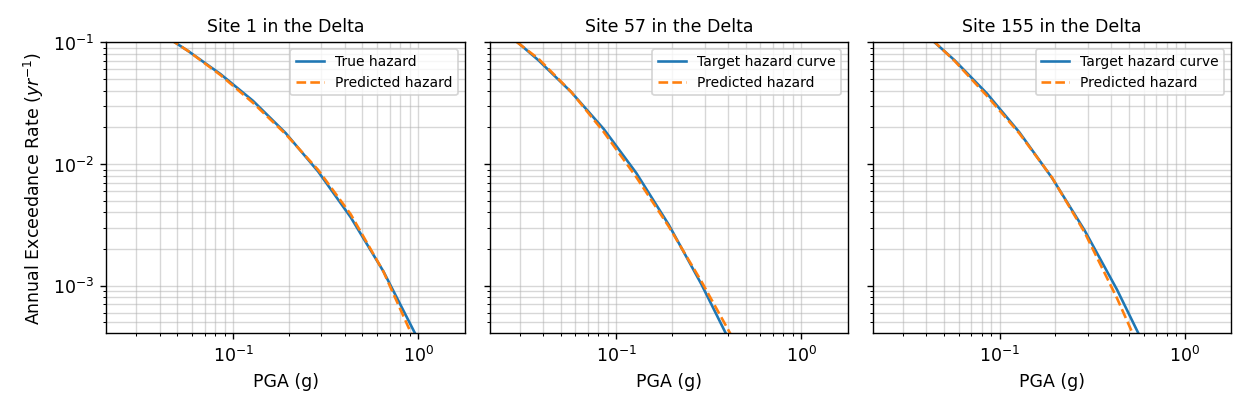

In [268]:
get_ipython().run_line_magic('matplotlib', 'notebook')
fig, ax = plt.subplots(1, 3,sharey=True, sharex=True)

ax[0].set_xlabel('PGA (g)')
ax[0].set_ylabel(r"Annual Exceedance Rate ($yr^{-1}$)")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_ylim([0.000404,0.1])
#ax[0].set_xlim([0.04,2])
ax[0].set_title('Site 1 in the Delta', fontsize="10")

ax[1].set_xlabel('PGA (g)')
ax[1].set_xscale("log")
ax[1].set_yscale("log")
#ax[1].set_xlim([0.02,1])
ax[1].set_title('Site 57 in the Delta',fontsize="10")

ax[2].set_xlabel('PGA (g)')
ax[2].set_xscale("log")
ax[2].set_yscale("log")
#ax[2].set_xlim([0.04,1])
ax[2].set_title('Site 155 in the Delta', fontsize="10")

ax[0].plot(PGA_val, target_y[:11] ,label='True hazard')
ax[0].plot(PGA_val, predict_y[:11] ,label='Predicted hazard',linestyle='dashed')
ax[1].plot(PGA_val, target_y[11:22] ,label='Target hazard curve')
ax[1].plot(PGA_val, predict_y[11:22] ,label='Predicted hazard',linestyle='dashed')
ax[2].plot(PGA_val, target_y[22:] ,label='Target hazard curve')
ax[2].plot(PGA_val, predict_y[22:] ,label='Predicted hazard',linestyle='dashed')

ax[0].grid(True, alpha=0.5, which='both')
ax[0].legend(fontsize="8")
ax[1].grid(True, alpha=0.5, which='both')
ax[1].legend(fontsize="8")
ax[2].grid(True, alpha=0.5, which='both')
ax[2].legend(fontsize="8")

fig.set_figheight(3.3)
fig.set_figwidth(10)
plt.tight_layout()
#plt.savefig('C:/Users/liuze/Downloads/pga1.png', dpi=600)

In [247]:
np.shape(yhat_mat)

(1727, 37)

In [248]:
EventSet

,EventID,Magnitude,AnnualOccurrenceRate,Fault_type,Rjb to Site1,Rjb to Site2,Rjb to Site3,Rjb to Site4,Rjb to Site5,Rjb to Site6,...,Rjb to Site148,Rjb to Site149,Rjb to Site150,Rjb to Site151,Rjb to Site152,Rjb to Site153,Rjb to Site154,Rjb to Site155,Rjb to Site156,Rjb to Site157
0,"FM31_780,779",5.401,0.0,SS,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709,...,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709,18.729709
1,"FM31_320,319",6.266,0.000005,SS,6.717505,6.717505,6.717505,6.717505,6.717505,6.717505,...,6.717505,6.717505,6.717505,6.717505,6.717505,6.717505,6.717505,6.717505,6.717505,6.717505
2,"FM31_781:775,952:954",6.503,0.000027,SS,16.244834,16.244834,16.244834,16.244834,16.244834,16.244834,...,16.244834,16.244834,16.244834,16.244834,16.244834,16.244834,16.244834,16.244834,16.244834,16.244834
3,"FM31_347:346,781:780",6.114,0.000011,SS,11.53171,11.53171,11.53171,11.53171,11.53171,11.53171,...,11.53171,11.53171,11.53171,11.53171,11.53171,11.53171,11.53171,11.53171,11.53171,11.53171
4,"FM31_348:346,781:780",6.344,0.000152,SS,11.520447,11.520447,11.520447,11.520447,11.520447,11.520447,...,11.520447,11.520447,11.520447,11.520447,11.520447,11.520447,11.520447,11.520447,11.520447,11.520447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,"FM32_-121.7,39.1,0.0_N",6.35,0.000002,N,118.04199,123.54466,113.060872,117.480525,123.007944,82.835614,...,140.918933,146.323804,150.655815,156.079987,165.866118,151.479189,156.875436,161.200433,157.972246,162.268592
1412,"FM32_-121.4,39.0,0.0_R",6.45,0.000001,R,114.239031,119.40426,108.491351,112.654878,117.888488,79.567636,...,125.894537,131.444112,135.88437,141.435359,151.428759,136.130082,141.671605,146.10582,142.086764,146.508633
1413,"FM32_-120.7,38.6,0.0_R",6.35,0.000001,R,121.233845,124.16161,115.211936,117.488553,120.504801,100.238251,...,97.094727,101.797974,105.620506,110.464515,119.341057,103.899955,108.819452,112.79788,106.88847,110.935149
1414,"FM32_-121.9,38.9,0.0_N",6.35,0.000003,N,94.515688,100.075434,90.172938,94.615852,100.170104,60.552047,...,125.545221,130.643962,134.74921,139.910216,149.2722,136.119462,141.2313,145.344446,142.985289,147.050307


In [269]:
####Extract the selected events
beta_selected_column = [arr[column_index] for arr in beta_mat]

idx_list = []
multipier_list = []
for i, val in enumerate(beta_selected_column):
    if val !=0:
        idx_list.append(i)
        multipier_list.append(val)
len(idx_list)

selected_events = EventSet.iloc[idx_list]
selected_events = selected_events.reset_index(drop=True)

AOR_N = []
for i, row in selected_events.iterrows():
    AOR_N.append(multipier_list[i]*row['AnnualOccurrenceRate'])
len(AOR_N)

PGA_selected_events = selected_events[['EventID', 'Magnitude', 'AnnualOccurrenceRate','Fault_type' ]]
#PGA_selected_events.loc[:, 'Adjusted AnnualOccurrenceRate'] = AOR_N
PGA_selected_events['Adjusted AnnualOccurrenceRate'] = AOR_N
PGA_selected_events

C:\Users\liuze\AppData\Local\Temp\ipykernel_13184\4106390334.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PGA_selected_events['Adjusted AnnualOccurrenceRate'] = AOR_N


,EventID,Magnitude,AnnualOccurrenceRate,Fault_type,Adjusted AnnualOccurrenceRate
0,"FM31_784,783",5.975,0.000001,SS,1.103543e-03
1,FM31_794:791,6.363,0.000005,SS,1.306186e-09
2,FM31_784:782,6.151,0.000026,SS,6.255628e-07
3,"FM31_581:580,201:207,828,842,841",6.98,0.0,SS,6.971798e-07
4,"FM31_775:781,1145:1144,318:320,788:785",7.181,0.0,SS,1.058826e-04
5,FM31_698:701,6.187,0.000003,SS,4.638074e-03
6,FM31_715:719,6.987,0.000004,SS,5.928267e-05
7,"FM31_-121.8,37.9,0.0_R",6.55,0.0,R,3.516547e-03
8,"FM31_-121.8,38.1,0.0_SS",6.85,0.0,SS,2.185692e-03
9,"FM31_-122.2,37.8,0.0_SS",6.95,0.0,SS,3.135552e-04


In [270]:
PGA_selected_events.to_csv('C:/Users/liuze/OneDrive/Desktop/Delta_Scenarios/PGA_matching_events.csv')

In [5]:
PGA_selected_events = pd.read_csv('C:/Users/liuze/OneDrive/Desktop/Delta_Scenarios/PGA_matching_events.csv')
PGA_selected_events = PGA_selected_events.drop('Unnamed: 0', axis=1)
PGA_selected_events

,EventID,Magnitude,AnnualOccurrenceRate,Fault_type,Adjusted AnnualOccurrenceRate
0,"FM31_784,783",5.975,1.025943e-06,SS,1.103543e-03
1,FM31_794:791,6.363,4.707834e-06,SS,1.306186e-09
2,FM31_784:782,6.151,2.606559e-05,SS,6.255628e-07
3,"FM31_581:580,201:207,828,842,841",6.980,4.750001e-08,SS,6.971798e-07
4,"FM31_775:781,1145:1144,318:320,788:785",7.181,2.452880e-07,SS,1.058826e-04
5,FM31_698:701,6.187,2.713384e-06,SS,4.638074e-03
6,FM31_715:719,6.987,4.267639e-06,SS,5.928267e-05
7,"FM31_-121.8,37.9,0.0_R",6.550,4.335879e-07,R,3.516547e-03
8,"FM31_-121.8,38.1,0.0_SS",6.850,4.960816e-07,SS,2.185692e-03
9,"FM31_-122.2,37.8,0.0_SS",6.950,1.609461e-07,SS,3.135552e-04


In [230]:
len(beta_mat)

1416

In [233]:
np.shape(beta_mat)
row_idx = []
for i in range(len(beta_mat)):
    if beta_mat[i][column_index] != 0:
        row_idx.append(i)
sel_events = EventSet.iloc[row_idx]
len(sel_events)

36

In [234]:
sel_events.to_csv('C:/Users/liuze/OneDrive/Desktop/Delta_Scenarios/APGA_matching_events.csv')

# PGA and Magnitude Matching 

In [41]:
rDeagg_to_MR_Hazd = robjects.r['Deagg_to_MR_Hazd']
rEvent_to_MR_Hazd = robjects.r['Event_to_MR_Hazd']

In [131]:
Y_Deagg

,ReturnPeriod,AnnualExceedanceRate,IM_level,IM_type,SiteName,R_distance,Magnitude,HazardContribution,Epsilon_bar
0,10,0.100000,0.048430,PGA,Delta Site1,10.0,5.1,3.85,-0.81
1,10,0.100000,0.048430,PGA,Delta Site1,10.0,5.3,3.21,-1.35
2,10,0.100000,0.048430,PGA,Delta Site1,10.0,5.5,2.44,-1.92
3,10,0.100000,0.048430,PGA,Delta Site1,10.0,5.7,1.61,-2.13
4,10,0.100000,0.048430,PGA,Delta Site1,10.0,5.9,1.02,-2.35
...,...,...,...,...,...,...,...,...,...
74981,2475,0.000404,0.524751,PGA,Delta Site157,70.0,7.9,0.05,2.36
74982,2475,0.000404,0.524751,PGA,Delta Site157,70.0,8.1,0.10,2.16
74983,2475,0.000404,0.524751,PGA,Delta Site157,90.0,7.9,0.14,2.83
74984,2475,0.000404,0.524751,PGA,Delta Site157,90.0,8.1,0.43,2.63


In [153]:
#### Marginal distribution of magnitude based on deaggregation
# Assuming your dataframe is named 'df'
# Group by 'Magnitude' and 'ReturnPeriod', and aggregate sum for 'HazardContribution' and 'Epsilon_bar'
Y_Deagg_drop = Y_Deagg.drop(columns=['R_distance'])

grouped = Y_Deagg_drop.groupby(['ReturnPeriod', 'AnnualExceedanceRate','SiteName','IM_level','Magnitude']).agg({
    'HazardContribution': 'sum',
    'Epsilon_bar': 'sum'
}).reset_index()

pga = ['PGA']*len(grouped)
grouped['IM_type'] = pga
grouped

,ReturnPeriod,AnnualExceedanceRate,SiteName,IM_level,Magnitude,HazardContribution,Epsilon_bar,IM_type
0,10,0.100000,Delta Site1,0.048430,5.1,7.90,5.77,PGA
1,10,0.100000,Delta Site1,0.048430,5.3,9.13,5.78,PGA
2,10,0.100000,Delta Site1,0.048430,5.5,10.00,5.30,PGA
3,10,0.100000,Delta Site1,0.048430,5.7,8.44,6.37,PGA
4,10,0.100000,Delta Site1,0.048430,5.9,7.12,4.63,PGA
...,...,...,...,...,...,...,...,...
16003,2475,0.000404,Delta Site99,0.465685,7.5,1.89,6.72,PGA
16004,2475,0.000404,Delta Site99,0.465685,7.7,2.07,8.77,PGA
16005,2475,0.000404,Delta Site99,0.465685,7.9,0.22,9.72,PGA
16006,2475,0.000404,Delta Site99,0.465685,8.1,0.38,9.12,PGA


In [154]:
with (ro.default_converter + pandas2ri.converter).context():
    Y_Deagg_r = ro.conversion.get_conversion().py2rpy(grouped)

In [155]:
from rpy2.robjects import r

as_null = r['as.null']
y_M_hazd = rDeagg_to_MR_Hazd(Deagg_df=Y_Deagg_r, R_distance = as_null())

In [156]:
# y_M_hazd

In [157]:
y_M_hazd_p = robjects.conversion.rpy2py(y_M_hazd)
y_M_hazd_p

,IM_type,Deagg_level,SiteName,IM_level,Hazd,Magnitude
1,PGA,10,Delta Site1,0.048430,0.100000,5.1
2,PGA,10,Delta Site1,0.048430,0.091968,5.3
3,PGA,10,Delta Site1,0.048430,0.082686,5.5
4,PGA,10,Delta Site1,0.048430,0.072519,5.7
5,PGA,10,Delta Site1,0.048430,0.063939,5.9
...,...,...,...,...,...,...
16004,PGA,2475,Delta Site99,0.465685,0.000020,7.5
16005,PGA,2475,Delta Site99,0.465685,0.000013,7.7
16006,PGA,2475,Delta Site99,0.465685,0.000004,7.9
16007,PGA,2475,Delta Site99,0.465685,0.000003,8.1


In [164]:
EventSet.to_csv('C:/Users/liuze/OneDrive/Desktop/Delta_Scenarios/PGA_eventset.csv')

In [163]:
# for i in range(1, 158):
#     name = 'Rjb to Site'+str(i)
#     EventSet[name] = EventSet[name].astype(float)
Sitelist = SiteTable[['SiteName', 'Vs30', 'z1']]

values_to_assign = EventSet.iloc[1, 4:].values
Sitelist.loc[:, 'Rjb'] = values_to_assign

Sitelist = Sitelist['Rjb'].astype(float)
Sitelist_r = ro.conversion.py2rpy(Sitelist)

C:\Users\liuze\AppData\Local\Temp\ipykernel_18156\69188019.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sitelist.loc[:, 'Rjb'] = values_to_assign


In [50]:
# values_to_assign = EventSet.iloc[1, 4:].values
# Sitelist.loc[:, 'Rjb'] = values_to_assign
# Sitelist['Rjb'] = Sitelist['Rjb'].astype(float)
# Sitelist_r = ro.conversion.get_conversion().py2rpy(Sitelist)

In [51]:
# develop X MR hazard distributions from each event in EventSet
# row_num = len(y_M_hazd_p)
# col_num = len(EventSet)
# X_MR = np.zeros([row_num, col_num])

# for i, row in EventSet.iterrows():
#     Fault_type = EventSet['Fault_type']
#     Fault_type_r = ro.conversion.py2rpy(Fault_type)
    
#     Sitelist = SiteTable[['SiteName', 'Vs30', 'z1']]
#     Sitelist['Rjb'] = EventSet.iloc[i, 4:].values
#     values_to_assign = EventSet.iloc[i, 4:].values
#     Sitelist.loc[:, 'Rjb'] = values_to_assign
#     Sitelist['Rjb'] = Sitelist['Rjb'].astype(float)
#     Sitelist_r = ro.conversion.py2rpy(Sitelist)
    
    
    
#     tmp_event_MR = rEvent_to_MR_Hazd(MR_Hazd = y_M_hazd, Mag = row['Magnitude'], 
#                                    AnnualOccurrenceRate = row['AnnualOccurrenceRate'], 
#                                    Fault_type = Fault_type, region = 1, Sitelist = Sitelist_r)
    
#     tmp_event_MR_p = robjects.conversion.rpy2py(y_M_hazd)
#     X_MR[i] = tmp_event_MR_p['Hazd_event'].values

In [165]:
row = EventSet.loc[0]
Fault_type = EventSet['Fault_type']
Fault_type_r = ro.conversion.get_conversion().py2rpy(Fault_type)

Sitelist = SiteTable[['SiteName','Vs30', 'z1']]
Sitelist_r = ro.conversion.get_conversion().py2rpy(Sitelist)